In [1]:
from github import Github, ContentFile
from github.Repository import Repository
import zipfile
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

from typing import List

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)
covid.sort_values(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Date'], inplace=True)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Date'],
      dtype='object')


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
2330,66.0,NaN,Guam,US,4/2/20 23:25,13.4443,144.7937,82.0,3.0,0.0,0.0,"Guam, US",2020-04-02
2386,66.0,NaN,Guam,US,2020-04-03 22:46:37,13.4443,144.7937,84.0,4.0,0.0,0.0,"Guam, US",2020-04-03


Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hubei' 'Hunan'
 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Ningxia'
 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan' 'Tianjin'
 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
count                    1188
unique                     36
top       2020-03-16 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-04-15 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

          Date  
206 2020-03-11  
211 2020-03-12  
207 2020-03-11  
212 2020-03-12  


Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                      36
unique                     36
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-04-15 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                      56
unique                     56
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-04-15 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
2330,66.0,NaN,Guam,US,4/2/20 23:25,13.4443,144.7937,82.0,3.0,0.0,0.0,"Guam, US",2020-04-02
2386,66.0,NaN,Guam,US,2020-04-03 22:46:37,13.4443,144.7937,84.0,4.0,0.0,0.0,"Guam, US",2020-04-03
2440,66.0,NaN,Guam,US,4/4/20 23:34,13.4443,144.7937,93.0,4.0,0.0,0.0,"Guam, US",2020-04-04
2522,66.0,NaN,Guam,US,2020-04-05 23:06:45,13.4443,144.7937,112.0,4.0,0.0,0.0,"Guam, US",2020-04-05
2566,66.0,NaN,Guam,US,4/6/20 23:22,13.4443,144.7937,113.0,4.0,0.0,0.0,"Guam, US",2020-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2674,NaN,NaN,Yukon,Canada,2020-04-07 23:11:15,64.2823,-135.0000,7.0,0.0,0.0,0.0,",Yukon,Canada",2020-04-07
2700,NaN,NaN,Yukon,Canada,2020-04-08 22:58:44,64.2823,-135.0000,7.0,0.0,0.0,0.0,",Yukon,Canada",2020-04-08
2728,NaN,NaN,Yukon,Canada,2020-04-09 23:09:01,64.2823,-135.0000,7.0,0.0,0.0,0.0,",Yukon,Canada",2020-04-09
2757,NaN,NaN,Yukon,Canada,2020-04-10 23:01:26,64.2823,-135.0000,8.0,0.0,0.0,0.0,",Yukon,Canada",2020-04-10


In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

Get top n impacted countries

In [19]:
top_impacted = covid.groupby(by=['Country_Region', 'Date']).Confirmed.sum().\
    groupby(by='Country_Region').max().\
    nlargest(n=40, keep='all').to_frame()
top_impacted

,Confirmed
Country_Region,
US,635963.0
Spain,177644.0
Italy,165155.0
France,137875.0
Germany,134753.0
United Kingdom,99483.0
China,83356.0
Iran,76389.0
Turkey,69392.0


Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [20]:
def read_population():
    zip_files = glob.glob('API_SP*.zip')
    assert len(zip_files) == 1
    with zipfile.ZipFile(file=zip_files[0]) as zip_file:
        names = zip_file.namelist()
        data_file_name = next((n for n in names if n.startswith('API_SP')), None)
        assert data_file_name is not None
        with zip_file.open(data_file_name) as data_file:
            df = pd.read_csv(data_file, header=2)

    # drop empty columns
    df = df.dropna(axis='columns', how='all')

    # get value from last population column w/ non NaN value
    df['population'] = df.loc[:,'1960':].copy().ffill(axis=1).iloc[:, -1]

    # remove rows where we don't have a population value
    df = df[df.population.notnull()]

    # we only really need two columns
    df = df.loc[:, ['Country Name', 'population']]
    
    df = df.set_index('Country Name')


    return df

def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [21]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [22]:
missing_countries = [c for c in top_impacted.index if c not in population.index]
missing_countries

['US', 'Iran', 'Russia', 'Korea, South']

In [23]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [24]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted.index if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries and only with the sum per country and date. And add relative values

In [25]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Date', 'Country_Region']).sum().reset_index()
#covid = covid.drop(columns=['Date'])
covid = covid[covid.Country_Region.isin(top_impacted.index)]

In [26]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.Country_Region].PopTotal.values * 100

In [27]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2423 entries, 0 to 8193
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2423 non-null   datetime64[ns]
 1   Country_Region      2423 non-null   object        
 2   Confirmed           2423 non-null   float64       
 3   Deaths              2423 non-null   float64       
 4   Recovered           2423 non-null   float64       
 5   Active              2423 non-null   float64       
 6   Confirmed_per_100k  2423 non-null   float64       
 7   Deaths_per_100k     2423 non-null   float64       
 8   Recovered_per_100k  2423 non-null   float64       
 9   Active_per_100k     2423 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 208.2+ KB


In [28]:
covid_max = covid.groupby(by='Country_Region').max()
coivd_max = covid_max.drop(columns='Date')
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, Australia to United Kingdom
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     40 non-null     datetime64[ns]
 1   Confirmed                40 non-null     float64       
 2   Deaths                   40 non-null     float64       
 3   Recovered                40 non-null     float64       
 4   Active                   40 non-null     float64       
 5   Confirmed_per_100k       40 non-null     float64       
 6   Deaths_per_100k          40 non-null     float64       
 7   Recovered_per_100k       40 non-null     float64       
 8   Active_per_100k          40 non-null     float64       
 9   population               40 non-null     float64       
 10  recovered_per_confirmed  40 non-null     float64       
 11  deaths_per_confirmed     40 non-null     float64       
dtypes: datetime64[ns](1), f

In [29]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

,Confirmed,Deaths
Country_Region,,
US,635963.0,28310.0
Spain,177644.0,18708.0
Italy,165155.0,21645.0
France,137875.0,17188.0
Germany,134753.0,3804.0
United Kingdom,99483.0,12894.0
China,83356.0,3346.0
Iran,76389.0,4777.0
Turkey,69392.0,1518.0


In [30]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

,Confirmed_per_100k,Confirmed,Deaths
Country_Region,,,
Spain,380.094633,177644.0,18708.0
Switzerland,306.540489,26336.0,1239.0
Belgium,290.944202,33573.0,4440.0
Italy,272.757637,165155.0,21645.0
Ireland,256.979112,12547.0,444.0
France,211.692875,137875.0,17188.0
US,193.263690,635963.0,28310.0
Portugal,176.908714,18091.0,599.0
Netherlands,165.618508,28316.0,3145.0


In [31]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

,Confirmed,Deaths,deaths_per_confirmed
Country_Region,,,
Belgium,33573.0,4440.0,0.132249
Italy,165155.0,21645.0,0.131059
United Kingdom,99483.0,12894.0,0.129610
France,137875.0,17188.0,0.124664
Netherlands,28316.0,3145.0,0.111068
Spain,177644.0,18708.0,0.105312
Sweden,11927.0,1203.0,0.100864
Indonesia,5136.0,469.0,0.091316
Mexico,5399.0,406.0,0.075199


In [32]:
covid

,Date,Country_Region,Confirmed,Deaths,Recovered,Active,Confirmed_per_100k,Deaths_per_100k,Recovered_per_100k,Active_per_100k
0,2020-01-22,China,547.0,17.0,28.0,502.0,0.038151,0.001186,0.001953,0.035012
2,2020-01-22,Japan,2.0,0.0,0.0,2.0,0.001577,0.000000,0.000000,0.001577
3,2020-01-22,"Korea, South",1.0,0.0,0.0,1.0,0.001952,0.000000,0.000000,0.001952
7,2020-01-22,US,1.0,0.0,0.0,1.0,0.000304,0.000000,0.000000,0.000304
8,2020-01-23,Australia,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
8179,2020-04-15,Switzerland,26336.0,1239.0,15400.0,9697.0,306.540489,14.421464,179.249830,112.869195
8188,2020-04-15,Turkey,69392.0,1518.0,5674.0,62200.0,83.174310,1.819498,6.800943,74.553869
8189,2020-04-15,US,635963.0,28310.0,52096.0,555557.0,193.263690,8.603166,15.831527,168.828997
8192,2020-04-15,United Arab Emirates,5365.0,33.0,1034.0,4298.0,54.910043,0.337750,10.582849,43.989443


In [33]:
top_5_confirmed = covid_max.nlargest(n=5, columns='Confirmed', keep='all')
top_5_confirmed

,Date,Confirmed,Deaths,Recovered,Active,Confirmed_per_100k,Deaths_per_100k,Recovered_per_100k,Active_per_100k,population,recovered_per_confirmed,deaths_per_confirmed
Country_Region,,,,,,,,,,,,
US,2020-04-15,635963.0,28310.0,52096.0,555557.0,193.263690,8.603166,15.831527,168.828997,329064917.0,0.081917,0.044515
Spain,2020-04-15,177644.0,18708.0,70853.0,88083.0,380.094633,40.028430,151.600082,188.466121,46736782.0,0.398848,0.105312
Italy,2020-04-15,165155.0,21645.0,38092.0,105418.0,272.757637,35.747262,62.909896,174.100479,60550092.0,0.230644,0.131059
France,2020-04-15,137875.0,17188.0,31470.0,94888.0,211.692875,26.390405,48.318947,145.690760,65129731.0,0.228250,0.124664
Germany,2020-04-15,134753.0,3804.0,72600.0,72864.0,161.347900,4.554759,86.928362,87.244465,83517046.0,0.538764,0.028229


In [34]:
column = 'Confirmed_per_100k'
top_countries = covid_max.nlargest(n=5, columns=column, keep='all').sort_values(by=column, ascending=False)
p = covid[covid.Country_Region.isin(top_countries.index)].\
    pivot_table(index=['Date'], columns=['Country_Region'], values=column)

p = p.reindex(columns=top_countries.index)
p

Country_Region,Spain,Switzerland,Belgium,Italy,Ireland
Date,,,,,
2020-01-31,NaN,NaN,NaN,0.003303,NaN
2020-02-01,0.002140,NaN,NaN,0.003303,NaN
2020-02-02,0.002140,NaN,NaN,0.003303,NaN
2020-02-03,0.002140,NaN,NaN,0.003303,NaN
2020-02-04,0.002140,NaN,0.008666,0.003303,NaN
...,...,...,...,...,...
2020-04-11,348.819480,292.235421,242.804476,251.479387,182.857218
2020-04-12,356.958680,295.820418,256.921418,258.237428,197.747137
2020-04-13,363.951031,298.998028,265.084807,263.444686,218.064605


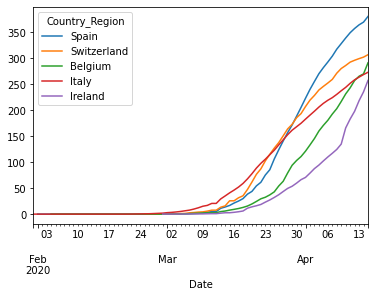

In [35]:
p.plot()

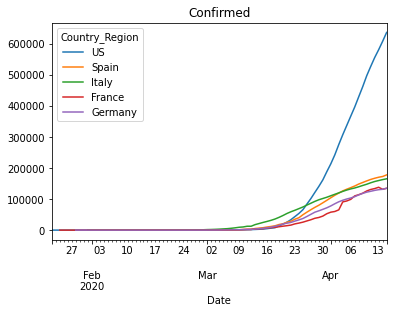

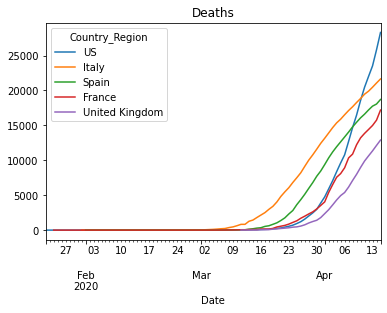

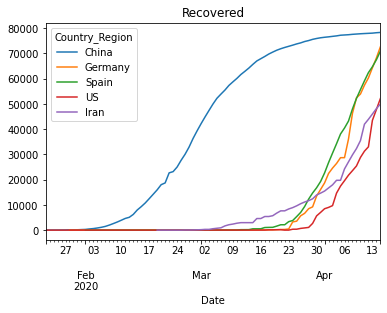

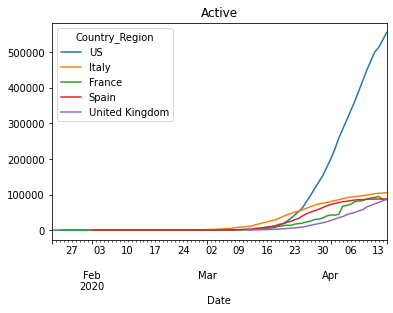

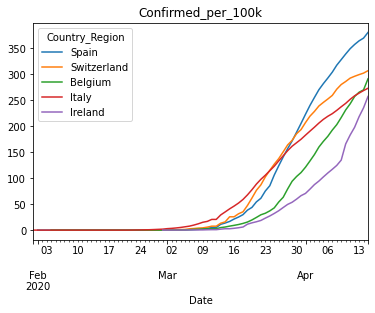

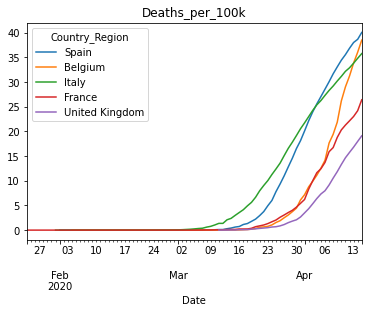

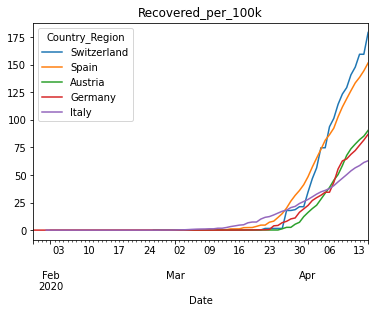

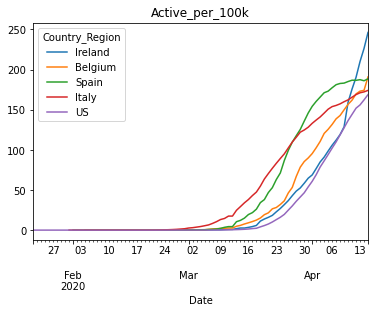

In [36]:
columns = covid.columns[2:]
for column in columns:
    top_countries = covid_max.nlargest(n=5, columns=column, keep='all').sort_values(by=column, ascending=False)
    p = covid[covid.Country_Region.isin(top_countries.index)].\
        pivot_table(index=['Date'], columns=['Country_Region'], values=column)

    p = p.reindex(columns=top_countries.index)
    p.plot(title=column, logy=False)


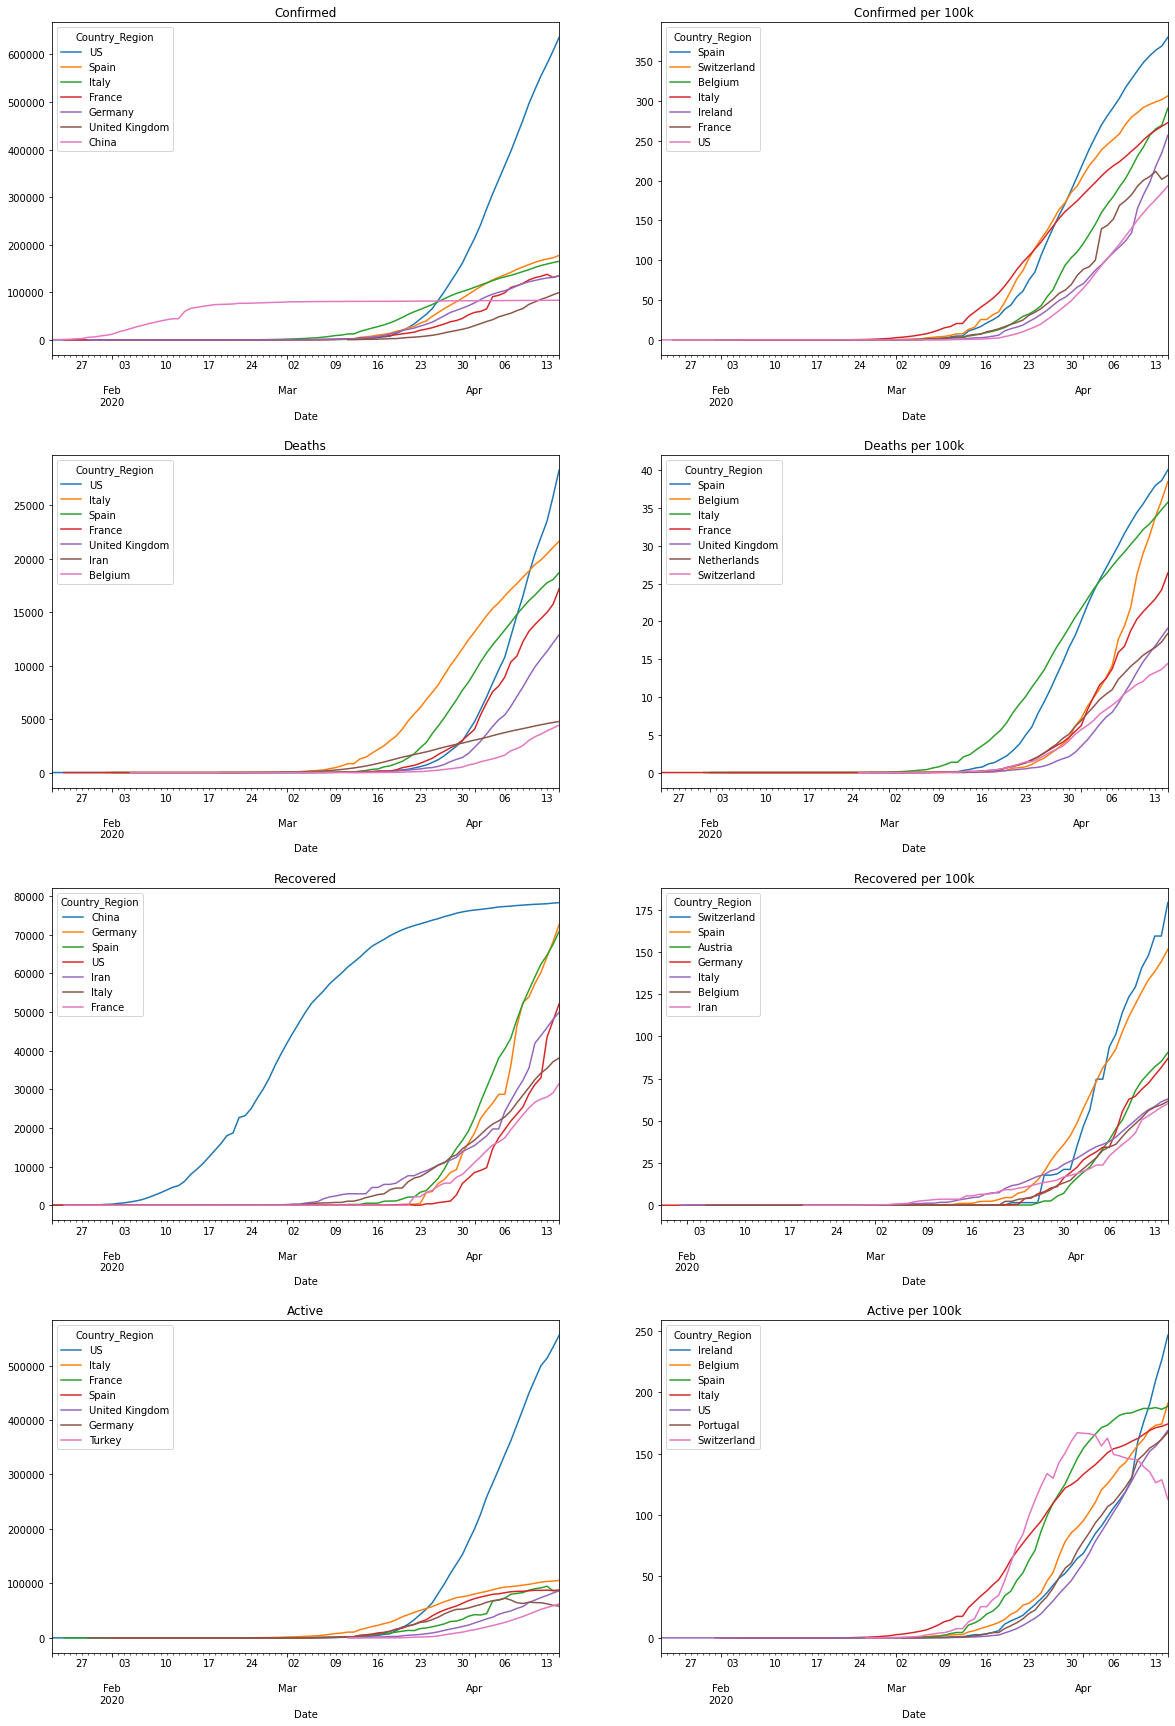

In [37]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
columns = covid.columns[2:]
for i, column in enumerate(columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=7, columns=column, keep='all').sort_values(by=column, ascending=False)
    p = covid[covid.Country_Region.isin(top_countries.index)].\
        pivot_table(index=['Date'], columns=['Country_Region'], values=column)

    p = p.reindex(columns=top_countries.index)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

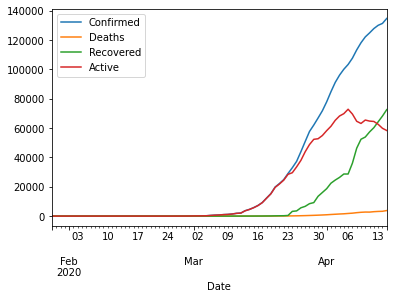

In [38]:
covid[covid.Country_Region=='Germany'].plot(x='Date',y=['Confirmed', 'Deaths', 'Recovered', 'Active'])

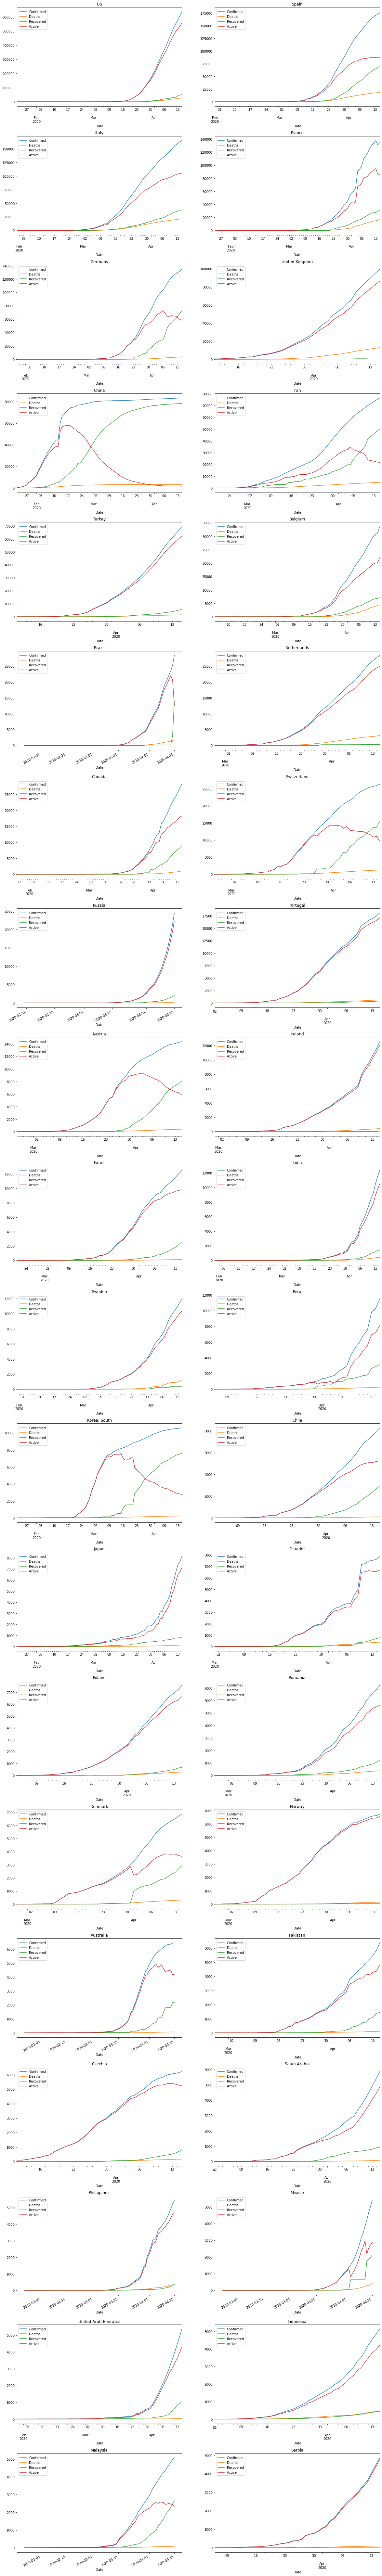

In [39]:
top_countries = covid_max.nlargest(n=40, columns='Confirmed', keep='all')
fig, axes = plt.subplots(20, 2, figsize=(20, 160))
for i, country in enumerate(top_countries.index):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid[covid.Country_Region==country].plot(x='Date',
                                              y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                                              ax = ax, title=country)
    

fig.subplots_adjust(hspace=0.3)